In [1]:
from pandas import read_csv
from matplotlib import pyplot
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras import Model

from keras.models import Sequential
from keras.layers import Dense, Input, Attention
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import *
from keras.models import *
from keras import backend as K

from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

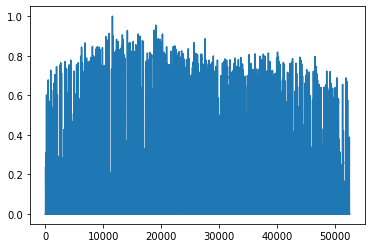

In [2]:
dataset = read_csv('solar_AL.txt', header=0, usecols = [2], engine='python')

dataset[:] = numpy.nan_to_num(dataset)    
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

plt.plot(dataset)
plt.show()
def create_dataset(dataset, look_back=1, look_ahead=0):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back - look_ahead-1):
        a = dataset[i:(i+look_back), 0]
        
        dataX.append(a)
        dataY.append(dataset[i + look_back + look_ahead, 0])
    return numpy.array(dataX), numpy.array(dataY)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#     print(len(train), len(test))
look_back = 1
look_ahead = 0


# Generator Code Using Fit function to train Proposed Model

In [3]:
#make model
def make_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(16, activation = 'tanh', kernel_initializer = 'he_normal'))
    model.add(Dense(8, activation = 'tanh', kernel_initializer = 'he_normal'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [4]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [5]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

Running for look_ahead 0
Running for look_ahead 1
Running for look_ahead 2
Running for look_ahead 3
Running for look_ahead 4
Running for look_ahead 5
Running for look_ahead 6
Running for look_ahead 7
Running for look_ahead 8
Running for look_ahead 9
Running for look_ahead 10
Running for look_ahead 11
Running for look_ahead 12
Running for look_ahead 13
Running for look_ahead 14
Running for look_ahead 15
Running for look_ahead 16
Running for look_ahead 17
Running for look_ahead 18
Running for look_ahead 19
Running for look_ahead 20


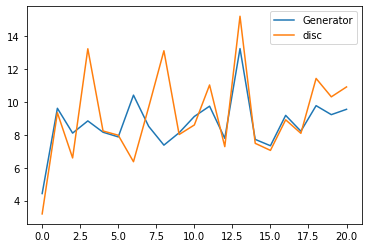

[4.431, 9.621, 8.111, 8.853, 8.164, 7.88, 10.421, 8.52, 7.378, 8.132, 9.124, 9.75, 7.794, 13.254, 7.727, 7.341, 9.19, 8.227, 9.781, 9.234, 9.559]
[3.192, 9.349, 6.599, 13.243, 8.239, 7.981, 6.369, 9.694, 13.122, 8.024, 8.606, 11.04, 7.287, 15.223, 7.488, 7.058, 8.92, 8.097, 11.437, 10.318, 10.921]


In [7]:
gen_losses = []
disc_losses = []
look_aheads = [3, 6, 12, 24]
for look_ahead in range(21):
    print("Running for look_ahead", look_ahead)
    trainX, trainY = create_dataset(train, look_back, look_ahead)
    testX, testY = create_dataset(test, look_back, look_ahead)
#     print(trainX.shape, [testX].shape, testY.shape)
    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
    generator = make_model()
    discriminator = make_model()
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
    
    for i in range(10):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_values = generator(trainX, training=True)
            decision = discriminator(trainX, training=True)
            
            gen_loss = tf.sqrt(tf.losses.mean_squared_error(trainY, generated_values))
            disc_loss = tf.sqrt(tf.losses.mean_squared_error(trainY - generated_values, decision))
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    testPredict = generator(testX, training = False)
    discPredict = discriminator(testX, training= False)
    ge_score = round(math.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], scaler.inverse_transform(testPredict))), 3)
    gen_losses.append(ge_score)
    di_score = round(math.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], scaler.inverse_transform(testPredict - discPredict))), 3)
    disc_losses.append(di_score)
plt.plot(gen_losses, label = "Generator")
plt.plot(disc_losses, label = "disc")
plt.legend()

plt.show()
print(gen_losses)
print(disc_losses)

# R- Squared Scores

In [15]:
gen_scores = []
disc_scores = []
look_aheads = [3, 6, 12, 24]
for look_ahead in look_aheads:
    trainX, trainY = create_dataset(train, look_back, look_ahead)
    testX, testY = create_dataset(test, look_back, look_ahead)
#     print(trainX.shape, [testX].shape, testY.shape)
    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
    generator = make_model()
    discriminator = make_model()
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
    
    for i in range(100):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_values = generator(trainX, training=True)
            decision = discriminator(trainX, training=True)
            
            gen_loss = tf.sqrt(tf.losses.mean_squared_error(trainY, generated_values))
            disc_loss = tf.sqrt(tf.losses.mean_squared_error(trainY - generated_values, decision))
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    testPredict = generator(testX, training = False)
    discPredict = discriminator(testX, training= False)
    ge_score = round(math.sqrt(r2_score(scaler.inverse_transform([testY])[0], scaler.inverse_transform(testPredict))), 3)
    gen_scores.append(ge_score)
    di_score = round(math.sqrt(r2_score(scaler.inverse_transform([testY])[0], scaler.inverse_transform(discPredict + testPredict))), 3)
    disc_scores.append(di_score)
plt.plot(gen_scores, label = "Generator")
plt.plot(disc_scores, label = "disc")
plt.legend()

plt.show()
print(gen_losses)
print(disc_losses)

KeyboardInterrupt: 

In [ ]:
#fit the data in the model
scores = []
for look_ahead in range(21):
    trainX, trainY = create_dataset(train, look_back, look_ahead)
    testX, testY = create_dataset(test, look_back, look_ahead)

    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
    model = make_model()
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    traingen = trainPredict
    testgen = testPredict

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    gen_testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    testScore = math.sqrt(mean_squared_error(testY[0], gen_testPredict[:,0]))
    scores.append(testScore)


# Generator using Code from Collab

In [ ]:
gen_losses = []
for look_ahead in range(0, 21):
    trainX, trainY = create_dataset(train, look_back, look_ahead)
    testX, testY = create_dataset(test, look_back, look_ahead)
#     print(trainX.shape, [testX].shape, testY.shape)
    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
    generator = make_model()
    discriminator = make_model()
    generator_optimizer = tf.keras.optimizers.Adam(1e-6)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)
    
    for i in range(10):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_values = generator(trainX, training=True)
        
            gen_loss = tf.sqrt(tf.losses.mean_squared_error(trainY, generated_values))
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    testPredict = generator(testX, training = False)
    
    ge_score = round(math.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], scaler.inverse_transform(testPredict))), 3)
    gen_losses.append(ge_score)


In [ ]:
plt.plot(scores, label = "Generator1")
plt.plot(gen_losses, label = "Generator2")
plt.legend()

plt.show()

# Generator and Discriminator Using Fit Function

In [ ]:
gen_losses = []
dis_losses = []
for look_ahead in range(0, 21):
    trainX, trainY = create_dataset(train, look_back, look_ahead)
    testX, testY = create_dataset(test, look_back, look_ahead)
#     print(trainX.shape, [testX].shape, testY.shape)
    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
    generator = make_model()
    discriminator = make_model()
    generator_optimizer = tf.keras.optimizers.Adam(1e-6)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-6)
    
    for i in range(3):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generator.fit(trainX, trainY)
            generated_values = generator(trainX)
            discriminator.fit(trainX, trainY - generated_values)
            decision = discriminator(trainX)
        
            gen_loss = tf.sqrt(tf.losses.mean_squared_error(trainY, generated_values))
            disc_loss = tf.sqrt(tf.losses.mean_squared_error(trainY - generated_values, decision))

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, generator.trainable_variables))
        
    testPredict = generator(testX)
    discPredict = discriminator(testX)
    gen_score = round(math.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], scaler.inverse_transform(testPredict))), 3)
    gen_losses.append(gen_score)
    dis_score = round(math.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], scaler.inverse_transform(discPredict))), 3)
    dis_losses.append(dis_score)
    


In [ ]:
plt.plot(gen_losses, label = "Generator")
plt.plot(dis_losses, label = "disc")
plt.legend()

plt.show()